In [1]:
import glob
import math
import os
import scipy.stats
import sys
sys.path.append('/Users/rsingh/Oyla/Work/our_python_dev/')

In [2]:
import open3d as o3d
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
from oyla.mvc.utils import *
from oyla.enhancement.utils import depth_to_xyz_view_img

In [3]:
from skimage.segmentation import felzenszwalb
from skimage.exposure import equalize_hist

In [4]:
def depth_to_bird_view_img(pcd, factor=1, INPUT_WIDTH=None, INPUT_HEIGHT=None,X_MAX=1620,X_MIN=-1620,Z_MAX=5000,Z_MIN=0 ):
    # Input:
    #   pcd: (N', 4)
    # Output:
    #   birdview: (w, l, 3)
    #Z_MAX, X_MAX,Y_MAX = np.max(np.asarray(pcd.points),axis=0)
    #Z_MIN, X_MIN,Y_MIN = np.min(np.asarray(pcd.points),axis=0)
    print(np.max(np.asarray(pcd.points),axis=0),np.min(np.asarray(pcd.points),axis=0))
    if INPUT_WIDTH is None:
        VOXEL_X_SIZE = 16
        VOXEL_Z_SIZE = 16
        INPUT_WIDTH = int((X_MAX - X_MIN) / VOXEL_X_SIZE)
        INPUT_HEIGHT = int((Z_MAX - Z_MIN) / VOXEL_Z_SIZE)
    else:
        VOXEL_X_SIZE = (X_MAX-X_MIN)/INPUT_WIDTH
        VOXEL_Z_SIZE = (Z_MAX-Z_MIN)/INPUT_HEIGHT
    birdview = np.zeros(
        (INPUT_HEIGHT * factor+1, INPUT_WIDTH * factor+1))
    for point in np.asarray(pcd.points):
        y,x,z = point[0:3]
        #if X_MIN < x < X_MAX and cfg.Y_MIN < y < cfg.Y_MAX:
        x, z = int((x - X_MIN) / VOXEL_X_SIZE *factor), int((z - Z_MIN) / VOXEL_Z_SIZE * factor)
        birdview[z, INPUT_WIDTH-x] += 1
    birdview = birdview - np.min(birdview)
    divisor = np.max(birdview) - np.min(birdview)
    # TODO: adjust this factor
    birdview = np.clip((birdview / divisor * 255) *
                       5 * factor, a_min=0, a_max=255)
    #birdview = np.tile(birdview, 3).astype(np.uint8)

    return birdview

In [60]:
dir_path='/Users/rsingh/Data/44x33/oyla_1_camera_v2/16_Feb_data_February_16_18_47_42///'

In [61]:
input_data_folder_name =  dir_path
csv_file = input_data_folder_name+'/parameters.csv'
parameters = read_csv_parameters(csv_file)
filter_params = {}
ambiguity_distance, range_max, range_min, saturation_flag, adc_flag, mod_freq, ampl_min,reflectivity_thresh = some_common_utility(parameters,0)

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [74]:
index = np.random.randint(0,500)
#index=400
#index = 125
#index =497
print(index)
data = scipy.io.loadmat(dir_path+'/data_1_'+str(index)+'.mat')['data']

rgb = data[0][4]
raw_phase = data[0][2][0][0][:,:,0]
raw_ampl = data[0][2][0][0][:,:,1]
rgb,raw_phase,raw_ampl = camera_calibrations(rgb,depth=raw_phase,ampl=raw_ampl,camera_version='oyla_1_camera_v2')
#_rgb = cv2.resize(rgb,None,fx=120/212,fy=120/212)
_rgb = rgb.astype('float32')/255.0

filtered_phase, thresholded_ampl, indices = threshold_filter(raw_phase = raw_phase, raw_ampl = raw_ampl, reflectivity_thresh= reflectivity_thresh,
                                                                             range_max = range_max, range_min = range_min, ampl_min = ampl_min,
                                                                             filter_params = filter_params, ambiguity_distance = ambiguity_distance)
_filtered_phase = filtered_phase.astype('float32')/np.max(filtered_phase)
_thresholded_ampl = thresholded_ampl.astype('float32')/np.max(thresholded_ampl)

432


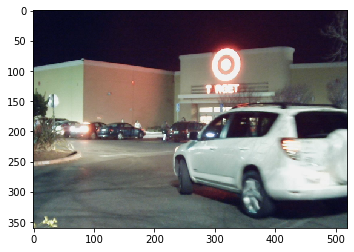

In [75]:
plt.imshow(rgb)

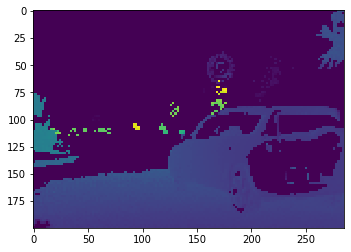

In [76]:
plt.imshow(((filtered_phase)))

In [77]:
_fez = felzenszwalb(filtered_phase,multichannel=False,min_size=50,sigma=1.5,scale = 500)

(134,)


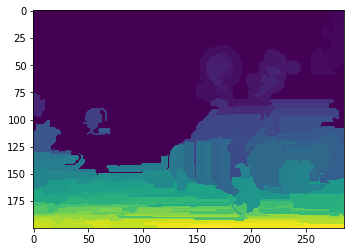

In [78]:
plt.imshow((_fez))
print(np.unique(_fez).shape)

In [79]:
mask = 0*_fez
mask[np.where((_fez==0) & (_filtered_phase>0))]=1

(134,)


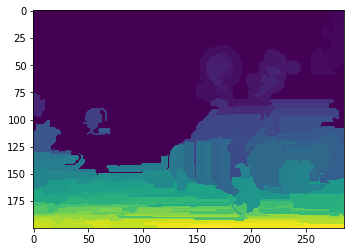

In [80]:
plt.imshow((_fez))
print(np.unique(_fez).shape)

In [81]:
_fez = felzenszwalb(_thresholded_ampl,multichannel=False,min_size=20,sigma=0.8,scale=100)

(92,)


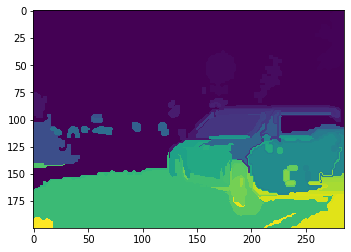

In [82]:
plt.imshow(((_fez)))
print(np.unique(_fez).shape)

In [83]:
pcd = o3d.io.read_point_cloud(os.path.join(dir_path,'kitti')+'/3d/oyla_'+str(index).zfill(4)+'.xyz',format='xyz')

In [84]:
o3d.visualization.draw_geometries([pcd])

In [85]:
cmap = plt.get_cmap("tab20")
labels = np.array(pcd.cluster_dbscan(eps=100, min_points=20, print_progress=True))
max_label = labels.max()
print('unique labels with counts',np.unique(labels,return_counts=True))

colors = cmap(labels / (max_label if max_label > 0 else 1))
colors[labels <0] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

unique labels with counts (array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int32), array([  148, 18652,   752,    72,    24,    28,    84,    20,   204,
          32,    40]))


In [86]:
y_max = range_max*np.sin(44/360*np.pi)+200/2
y_min = -y_max
z_max = range_max
z_min = 0
x_max = range_max*np.sin(33/360*np.pi)+286/2
x_min = -x_max

In [87]:
bev = depth_to_xyz_view_img(pcd,  a_max=y_max, a_min=y_min, b_max =z_max, b_min=z_min, view = 'yz')
print(bev.shape)

(313, 247)


In [88]:
y_max

1973.03296707956

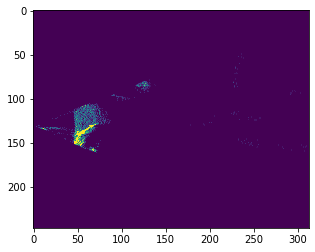

In [89]:
plt.imshow(np.rot90(bev))

In [90]:
def lidar_to_top(lidar):

    idx = np.where (lidar[:,0]>TOP_X_MIN)
    lidar = lidar[idx]
    idx = np.where (lidar[:,0]<TOP_X_MAX)
    lidar = lidar[idx]

    idx = np.where (lidar[:,1]>TOP_Y_MIN)
    lidar = lidar[idx]
    idx = np.where (lidar[:,1]<TOP_Y_MAX)
    lidar = lidar[idx]

    idx = np.where (lidar[:,2]>TOP_Z_MIN)
    lidar = lidar[idx]
    idx = np.where (lidar[:,2]<TOP_Z_MAX)
    lidar = lidar[idx]



    pxs=lidar[:,0]
    pys=lidar[:,1]
    pzs=lidar[:,2]
    if lidar.shape[1]==4:
        prs=lidar[:,3]
    else:
        prs = np.zeros_like(lidar[:,2])
    qxs=((pxs-TOP_X_MIN)//TOP_X_DIVISION).astype(np.int32)
    qys=((pys-TOP_Y_MIN)//TOP_Y_DIVISION).astype(np.int32)
    #qzs=((pzs-TOP_Z_MIN)//TOP_Z_DIVISION).astype(np.int32)
    qzs=(pzs-TOP_Z_MIN)/TOP_Z_DIVISION
    quantized = np.dstack((qxs,qys,qzs,prs)).squeeze()

    X0, Xn = 0, int((TOP_X_MAX-TOP_X_MIN)//TOP_X_DIVISION)+1
    Y0, Yn = 0, int((TOP_Y_MAX-TOP_Y_MIN)//TOP_Y_DIVISION)+1
    Z0, Zn = 0, int((TOP_Z_MAX-TOP_Z_MIN)/TOP_Z_DIVISION)
    height  = Xn - X0
    width   = Yn - Y0
    channel = Zn - Z0  + 2
    # print('height,width,channel=%d,%d,%d'%(height,width,channel))
    top = np.zeros(shape=(height,width,channel), dtype=np.float32)
    print(channel)

    # histogram = Bin(channel, 0, Zn, "z", Bin(height, 0, Yn, "y", Bin(width, 0, Xn, "x", Maximize("intensity"))))
    # histogram.fill.numpy({"x": qxs, "y": qys, "z": qzs, "intensity": prs})

    if 1:  #new method
        for x in range(Xn):
            ix  = np.where(quantized[:,0]==x)
            quantized_x = quantized[ix]
            if len(quantized_x) == 0 : continue
            yy = -x

            for y in range(Yn):
                iy  = np.where(quantized_x[:,1]==y)
                quantized_xy = quantized_x[iy]
                count = len(quantized_xy)
                if  count==0 : continue
                xx = -y
                top[yy,xx,Zn+1] = min(1, np.log(count+1)/math.log(32))
                max_height_point = np.argmax(quantized_xy[:,2])
                top[yy,xx,Zn]=quantized_xy[max_height_point, 3]
                
                for z in range(Zn):
                    iz = np.where ((quantized_xy[:,2]>=z) & (quantized_xy[:,2]<=z+1))
                    quantized_xyz = quantized_xy[iz]
                    if len(quantized_xyz) == 0 : continue
                    zz = z
                    
                    #height per slice
                    max_height = max(0,np.max(quantized_xyz[:,2])-z)
                    top[yy,xx,zz]=max_height
                    print(max_height,zz)



    if 0: #unprocess
        top_image = np.zeros((height,width,3),dtype=np.float32)
    
        num = len(lidar)
        for n in range(num):
            x,y = qxs[n],qys[n]
            if x>=0 and x <height and y>0 and y<width:
                top_image[x,y,:] += 1
        print(np.where(top_image[:,:,0])[0].shape,num)
        max_value=np.max(np.log(top_image+0.001))
        print(np.max(top_image),max_value)
        top_image = top_image/max_value *255
        top_image=top_image.astype(dtype=np.uint8)
        top = top_image
    top = (np.rot90(top))

    return top

In [102]:
#2,1,0 bev
#1,0,2 fev
#2,0,1 sev
_tmp = np.asarray(pcd.points)[:,[2,1,0]]
TOP_Y_MIN = y_min
TOP_Y_MAX = y_max
TOP_X_MIN = z_min
TOP_X_MAX = z_max
TOP_Z_MIN = x_min
TOP_Z_MAX = x_max

TOP_X_DIVISION = 10
TOP_Y_DIVISION = 10
TOP_Z_DIVISION = 100

In [103]:
np.max(_tmp,axis=0)

array([4964.06   ,  615.71094,  334.5901 ])

In [104]:
(y_min,y_max)

(-1973.03296707956, 1973.03296707956)

In [105]:
views = lidar_to_top(_tmp)

33
0.6322249851961281 16
0.5873445351961273 16
0.6328374351961301 16
0.5812427751961273 16
0.5667297351961302 16
0.5046683351961292 16
0.6223416351961291 16
0.5493590751961293 16
0.5557705351961282 16
0.5698472851961291 16
0.6341269951961301 16
0.5541820351961277 16
0.47316988519612835 16
0.8134162351961294 16
0.5072479351961299 16
0.5357751351961291 16
0.5347067351961279 16
0.48538623519612756 16
0.5303245751961292 16
0.4220442351961289 16
0.33989623519612877 16
0.5238775851961286 16
0.4835710351961282 16
0.4995644351961275 16
0.379135385196129 16
0.5003582351961278 16
0.3877974351961271 16
0.44815409519612714 16
0.42595563519612867 16
0.39384573519612687 16
0.4543526351961269 16
0.42494669519613026 16
0.33610183519612846 16
0.399720035196129 16
0.413672885196128 16
0.46017333519613146 16
0.3931354351961289 16
0.27772623519612694 16
0.9947560351961293 16
0.34550608519613135 16
0.3900458351961298 16
0.27566983519612975 16
0.27571978519613083 16
0.5027140351961279 16
0.22823606519612838

0.9274490351961262 18
0.9240272351961281 18
0.9418979351961312 18
0.9262604351961308 18
0.91949123519613 18
0.8882648351961286 18
0.8875485351961281 18
0.9232736351961286 18
0.5633480951961296 15
0.9174637351961294 18
0.5635446301961284 15
0.9215579351961303 18
0.8416250351961292 15
0.9454748351961264 18
0.9195016351961307 18
0.9309289351961283 18
0.8769881351961288 17
0.887358735196127 18
0.8865155351961285 18
0.8955872351961283 18
0.923528735196129 18
0.9934035351961263 16
0.016050735196127874 17
0.8859602351961264 18
0.9932142351961275 16
0.015849635196126144 17
0.8848169351961275 18
0.8703032351961291 18
0.8471640351961298 18
0.9942976351961299 16
0.01700073519613099 17
0.8858682351961278 18
0.9940585351961282 16
0.05974123519612817 17
0.8443738351961301 18
0.923648435196128 18
0.05998143519612853 17
0.9220346351961268 18
0.06284383519613002 17
0.8913040351961286 18
0.9260632351961284 16
0.062499535196128164 17
0.8228015351961275 18
0.3805414851961295 16
0.889693635196128 18
0.9948

0.9110748351961284 18
0.8313278351961308 18
0.8795999351961292 18
0.880259235196128 18
0.8333066351961307 18
0.8776362351961282 18
0.8776697351961289 18
0.913950835196129 18
0.9286392351961297 18
0.9137356351961294 18
0.9127875351961272 18
0.9128946351961282 18
0.8814584351961265 18
0.8814340351961292 18
0.8677152351961297 18
0.8716159351961288 18
0.9264402351961287 18
0.5567548351961307 16
0.9188455351961267 18
0.5567673351961275 16
0.873380435196129 18
0.919057635196129 18
0.9185367351961276 18
0.7136752351961277 17
0.8678762351961282 18
0.9008414351961278 17
0.8686810351961292 18
0.5915880351961285 17
0.8333232351961293 18
0.36072153519612726 16
0.9508502351961283 17
0.9239042351961295 18
0.5075104351961279 16
0.09696703519612981 17
0.9230472351961296 18
0.9520375351961263 16
0.8816528351961281 18
0.9518938351961275 16
0.8806790351961276 18
0.5074885351961278 16
0.864749235196129 18
0.5568786351961279 16
0.8699408351961289 18
0.8595776351961284 18
0.8739746351961273 18
0.82830223519

0.8250928351961271 18
0.7692456351961283 18
0.7620952351961279 18
0.7701330351961282 18
0.8796677351961293 18
0.8083496351961266 18
0.8101379351961278 18
0.8738942351961292 18
0.8253772351961288 18
0.8268719351961309 18
0.8661972351961289 18
0.8211702351961279 18
0.6961905351961271 18
0.9271362351961301 18
0.7798092351961294 18
0.92146853519613 18
0.8108575351961278 18
0.7519152351961296 18
0.8707182351961258 18
0.8713095351961293 18
0.8867572351961286 18
0.8721490351961272 18
0.8176849351961302 18
0.8275872351961304 18
0.836438035196128 18
0.8363504351961275 18
0.8294260351961285 18
0.8105148351961304 17
0.9711041351961285 17
0.8249002351961288 18
0.9131395351961267 17
0.8203172351961285 18
0.09487123519612695 17
0.8139874351961289 18
0.44063608519612885 16
0.09178273519613 17
0.9316948351961294 16
0.03869123519612927 17
0.9832895351961284 16
0.9295138351961292 16
0.1409910351961301 18
0.14047103519612847 18
0.20157353519612897 18
0.20094023519612847 18
0.8102554351961295 18
0.8130246

0.7869528351961286 18
0.8655582351961293 18
0.7944232351961276 18
0.7947745351961295 18
0.791095035196129 18
0.8655922351961287 18
0.9084080351961283 17
0.8657942351961303 18
0.9676422351961271 17
0.7261242351961315 18
0.4078348351961303 17
0.8702092351961284 18
0.8002008351961294 18
0.79358953519613 18
0.7855307351961294 18
0.7861533351961292 16
0.7874158351961285 18
0.7872369351961304 18
0.7897247351961276 18
0.6894855351961304 18
0.8584248351961286 14
0.9831285351961281 14
0.9170465351961301 14
0.6644540351961297 14
0.32890553519612986 14
0.868272735196129 13
0.65251323519613 14
0.8710959351961289 13
0.6545675851961281 14
0.908368335196128 14
0.7413599351961295 18
0.6902420351961283 18
0.6198952351961289 18
0.6265408351961277 18
0.563349235196128 18
0.7438705351961303 18
0.35834293519612714 18
0.6298770351961274 18
0.5552664351961276 18
0.6930029351961267 18
0.8069897351961295 18
0.6177997351961295 18
0.6947032351961298 18
0.7433307351961282 18
0.7573322351961309 18
0.75839483519612

0.5321482351961286 18
0.5999588351961265 18
0.5282892351961301 18
0.5285699351961277 18
0.5457025351961278 18
0.5465170351961284 18
0.55256123519613 18
0.5530408351961285 18
0.5613858351961305 18
0.5617554351961296 18
0.49410003519613 18
0.5700632351961268 18
0.7765530351961303 17
0.5090295351961274 18
0.509307235196129 18
0.5208975351961307 18
0.5311496351961296 18
0.3875848351961295 18
0.3893967351961294 18
0.5661236351961279 18
0.5664662351961276 18
0.4184555351961272 18
0.26418723519612897 18
0.42417753519612944 18
0.42605683519612825 18
0.36080923519612895 18
0.2773935351961292 18
0.2739847351961302 18
0.43768283519612794 18
0.4499892351961279 18
0.3731528351961302 18
0.27911863519612723 18
0.3847870351961262 18
0.3859515351961278 18
0.385703735196131 18
0.4642816351961301 18
0.3866542351961293 18
0.38776153519612677 18
0.3874847351961286 18
0.3330694351961263 18
0.4213129351961271 18
0.42401763519612956 18
0.4258078351961281 18
0.34302623519613107 18
0.43349853519612935 18
0.3897

0.668991185196127 14
0.6693523351961286 14
0.3548195151961302 15
0.3547229051961285 15
0.5846800351961292 15
0.5846008201961279 15
0.8124400951961306 15
0.812378125196128 15
0.8736434351961293 14
0.8740689351961279 14
0.870460535196127 14
0.8707336351961299 14
0.6289692351961271 14
0.629395835196128 14
0.2766141751961264 16
0.27657709519612794 16
0.8521164951961282 14
0.851930485196128 14
0.6756969351961288 13
0.6762839351961301 13
0.36559783519612843 13
0.36629363519612923 13
0.2176005351961301 13
0.34789753519613065 13
0.34864493519612694 13
0.5703331351961296 17
0.5706636351961301 17
0.8433943351961268 17
0.84382083519613 17
0.8441528351961267 17
0.8445619351961291 17
0.306832435196128 17
0.3070703351961299 17
0.24659733519612992 13
0.24741683519612856 13
0.31007463519613054 17
0.31032353519612954 17
0.5885887351961294 17
0.5889397351961279 17
0.8809070351961275 12
0.8817605351961291 12
0.6098146351961269 17
0.6101446351961286 17
0.9728467351961285 12
0.11328803519612762 13
0.973520

In [106]:
views.shape

(395, 501, 33)

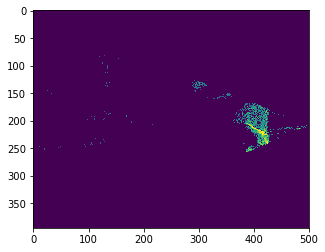

In [109]:
plt.imshow(views[:,:,-1])

In [435]:
def sample_image(pc, density=None):
        pc=pc.copy()
        if density is None:
            density = 300
        print('sample density:', density)
        center=np.min(pc,axis=0)
        half_xyz=[0.2, 0.2, 0.3]
        width = half_xyz[0] * 2
        height = half_xyz[1] * 2
        depth = half_xyz[2] * 2
        #convert pc to normalized space
        pc[:, :] -= center
#         pc[:, 0] /= half_xyz[0]
#         pc[:, 1] /= half_xyz[1]
#         pc[:, 2] /= half_xyz[2]
        pc = pc/np.max(pc,axis=0)
        # self.pc_visualizer.show_pc(pc)

        #for every point, get its x,y, draw it on film
        sample_width = math.ceil(width * density)+1
        sample_height = math.ceil(height * density)+1
        sample_depth = math.ceil(depth * density)+1
        
        #sample from xy, yz, zx plane
        xy_image = np.ones((sample_height, sample_width))
        yz_image = np.ones((sample_height, sample_depth))
        zx_image = np.ones((sample_depth, sample_width))
        for point in pc:
            # c_x = math.ceil((point[0] + bounding_box.half_xyz[0]) * density)
            # c_y = math.ceil((point[1] + bounding_box.half_xyz[1]) * density)
            # c_x = int(round(((point[0] + bounding_box.half_xyz[0]) * density)))
            # c_y = int(round(((point[1] + bounding_box.half_xyz[1]) * density)))
            # c_z = int(round(((point[2] + bounding_box.half_xyz[2]) * density)))
            c_x = int(round(((point[0] + 1.0) * density * half_xyz[0])))
            c_y = int(round(((point[1] + 1.0) * density * half_xyz[1])))
            c_z = int(round(((point[2] + 1.0) * density * half_xyz[2])))
            if(point[2] < xy_image[c_y, c_x]): #nearest point
                xy_image[c_y, c_x] = point[2]
            if(point[0] < yz_image[c_y, c_z]): #nearest point
                yz_image[c_y, c_z] = point[0]
            if(point[1] < zx_image[c_z, c_x]): #nearest point
                zx_image[c_z, c_x] = point[1]

        return xy_image, yz_image, zx_image

In [444]:
def sample_image_w_pyramid(pc):
        #multi-scale
        num_scales = 1
        odensity = 300
        scale_factor=1.3
        xy_images = []
        yz_images = []
        zx_images = []
        for i in range(num_scales):
            density = odensity / scale_factor**i
            xy_image, yz_image, zx_image = sample_image(pc, density=density)
            
            xy_images.append(xy_image)
            yz_images.append(yz_image)
            zx_images.append(zx_image)
        
        final_xy_image = np.ones(xy_images[0].shape)
        final_yz_image = np.ones(yz_images[0].shape)
        final_zx_image = np.ones(zx_images[0].shape)

        for i in range(num_scales):
            c_xy_image = cv2.resize(xy_images[i], (final_xy_image.shape[1], final_xy_image.shape[0]), interpolation=cv2.INTER_NEAREST)
            c_yz_image = cv2.resize(yz_images[i], (final_yz_image.shape[1], final_yz_image.shape[0]), interpolation=cv2.INTER_NEAREST)
            c_zx_image = cv2.resize(zx_images[i], (final_zx_image.shape[1], final_zx_image.shape[0]), interpolation=cv2.INTER_NEAREST)

            index_pos_xy = np.where((final_xy_image == 1) & (c_xy_image != 1))
            index_pos_yz = np.where((final_yz_image == 1) & (c_yz_image != 1))
            index_pos_zx = np.where((final_zx_image == 1) & (c_zx_image != 1))

            final_xy_image[index_pos_xy] = c_xy_image[index_pos_xy]
            final_yz_image[index_pos_yz] = c_yz_image[index_pos_yz]
            final_zx_image[index_pos_zx] = c_zx_image[index_pos_zx]

        return final_xy_image, final_yz_image, final_zx_image

In [445]:
xy_image,yz_image,zx_image = sample_image_w_pyramid(pc=_tmp)

sample density: 300.0


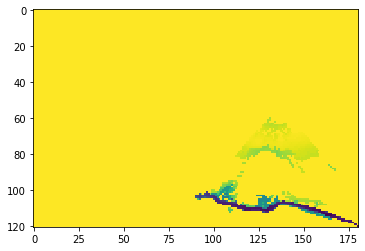

In [450]:
plt.imshow(np.transpose(zx_image))

In [181]:
_fez = felzenszwalb(bev.astype('float32')/np.max(bev),multichannel=False,min_size=20,sigma=1.4,scale = 100)

(78,)


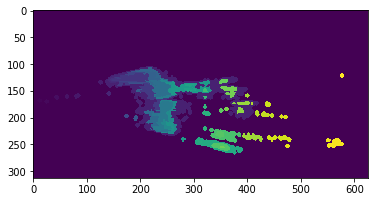

In [182]:
plt.imshow(np.rot90(_fez))
print(np.unique(_fez).shape)

In [6]:
dir_path='/Users/rsingh/Oyla Dropbox/Oyla/02 Technical/'+'10 Data/44x33/oyla_1_camera_v2/08_Feb_data_February_08_05_41_43//'

In [537]:
input_data_folder_name =  dir_path
csv_file = input_data_folder_name+'/parameters.csv'
parameters = read_csv_parameters(csv_file)
filter_params = {}
ambiguity_distance, range_max, range_min, saturation_flag, adc_flag, mod_freq, ampl_min,reflectivity_thresh = some_common_utility(parameters,0)

dict_keys(['Section', 'Type', 'Key', 'Argument Format', 'Value', 'Command Group', 'Description'])


In [48]:
filter_params['median_filter'] = 1
filter_params['median_filter_size'] = 3
filter_params['median_filter_iterations'] = 3
filter_params['edge_detection'] = 1
filter_params['edge_detection_thresholds'] = 100

In [538]:
index = np.random.randint(200,600) 
#index = 300
#index = 250
index =100
print(index)
data = scipy.io.loadmat(dir_path+'/data_1_'+str(index)+'.mat')['data']

rgb = data[0][4]
raw_phase = data[0][2][0][0][:,:,0]
raw_ampl = data[0][2][0][0][:,:,1]
rgb,raw_phase,raw_ampl = camera_calibrations(rgb,depth=raw_phase,ampl=raw_ampl,camera_version='oyla_1_camera_v2')
#_rgb = cv2.resize(rgb,None,fx=120/212,fy=120/212)
_rgb = rgb.astype('float32')/255.0

filtered_phase, thresholded_ampl, indices = threshold_filter(raw_phase = raw_phase, raw_ampl = raw_ampl, reflectivity_thresh= reflectivity_thresh,
                                                                             range_max = range_max, range_min = range_min, ampl_min = ampl_min,
                                                                             filter_params = filter_params, ambiguity_distance = ambiguity_distance)
_filtered_phase = filtered_phase.astype('float32')/np.max(filtered_phase)
_thresholded_ampl = thresholded_ampl.astype('float32')/np.max(thresholded_ampl)

100


In [539]:
__thresholded_ampl = cv2.resize(_thresholded_ampl,(_rgb.shape[1],_rgb.shape[0]))
_filtered_phase = cv2.resize(_filtered_phase,(_rgb.shape[1],_rgb.shape[0]))
__thresholded_ampl.shape

(360, 520)

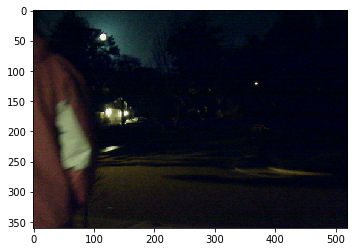

In [540]:
plt.imshow(rgb)

In [502]:
def Stransform(x,delta1=0,delta2=1,n=2,m=0.5):
    #https://www.isical.ac.in/~sarif_r/papers/naik-12tip12-hue.pdf
    y = np.zeros_like(x)
    
    ind = np.where((x<=m)&(x>=delta1))
    y[ind] = delta1+(m[ind]-delta1)*np.power((x[ind]-delta1)/(m[ind]-delta1+0.00001),n)
    ind = np.where((x>m)&(x<=delta2))
    y[ind] = delta2-(delta2-m[ind])*np.power((delta2-x[ind])/(delta2-m[ind]+0.00001),n)
    print(np.where(y>1))
    y[y>1] = 1
    y[y<0] = 0
    return y

(array([], dtype=int64), array([], dtype=int64))


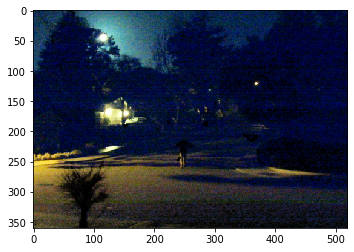

In [516]:
_hsv = cv2.cvtColor(_rgb,cv2.COLOR_RGB2HSV)
h,s,v = cv2.split(_hsv)
_v = v.copy()
__v = Stransform(_v,delta2=1.0,m=__thresholded_ampl,n=3)
ehsv = cv2.merge((h,s,__v))
ergb = cv2.cvtColor(ehsv,cv2.COLOR_HSV2RGB)
plt.imshow(ergb)

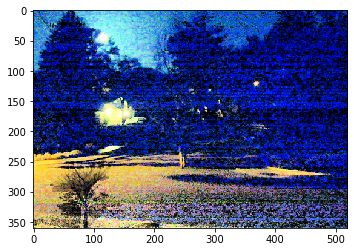

In [521]:
h,s,v = cv2.split(_hsv)
image_felzenszwalb = felzenszwalb(__thresholded_ampl,multichannel=False,min_size=50,sigma=0.5,scale=500)
_v = np.zeros_like(v)
for label in np.unique(image_felzenszwalb):
    #print(label)
    mask = np.zeros_like(image_felzenszwalb)
    mask[image_felzenszwalb==label] = 1
    #print(np.sum(mask))
    __v = equalize_hist(v,mask=mask)
    _v[image_felzenszwalb==label] = __v[image_felzenszwalb==label]
ehsv = cv2.merge((h,s,_v))
ergb = cv2.cvtColor(ehsv,cv2.COLOR_HSV2RGB)
plt.imshow(ergb)

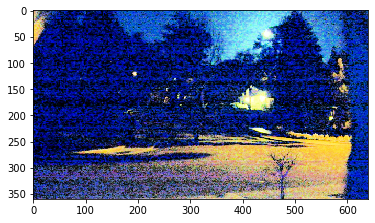

In [497]:
ergb2 = rgbEqualizeHistogram(_rgb)
plt.imshow(ergb2)

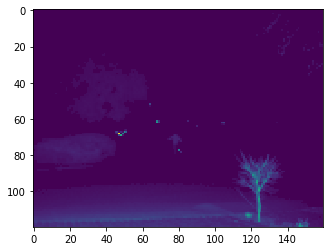

In [410]:
plt.imshow(((thresholded_ampl)))

In [411]:
print(rgb.shape,raw_phase.shape)

(360, 640, 3) (120, 160)


In [412]:
_fez = felzenszwalb(_rgb[:,:,0],multichannel=False,min_size=50,sigma=1.5,scale = 500)

(25,)


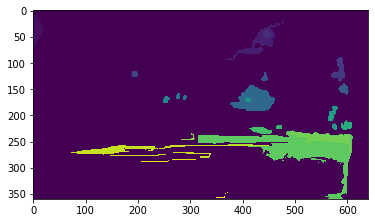

In [413]:
plt.imshow(_fez)
print(np.unique(_fez).shape)

In [414]:
_fez = felzenszwalb(_filtered_phase,multichannel=False,min_size=50,sigma=1.5,scale = 500)

(9,)
unique segs with counts (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([12353,    80,  2472,    72,   132,  3801,    80,   105,   105]))


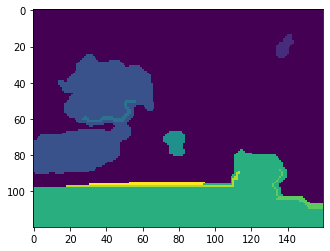

In [415]:
plt.imshow(((_fez)))
print(np.unique(_fez).shape)
print('unique segs with counts',np.unique(_fez,return_counts=True))


In [416]:
pcd = o3d.io.read_point_cloud(os.path.join(dir_path,'kitti')+'/3d/oyla_'+str(index).zfill(4)+'.xyz',format='xyz')

In [288]:
o3d.visualization.draw_geometries([pcd])

In [303]:
plane_model, _inliers = pcd.segment_plane(distance_threshold=2,
                                                 ransac_n=3,
                                                 num_iterations=100)
inlier_cloud = pcd.select_down_sample(_inliers)
o3d.visualization.draw_geometries([inlier_cloud])

In [304]:
np.mean(np.asarray(pcd.points)[_inliers],axis=0)

array([ 423.72521376,  289.22492364, 1345.1244252 ])

In [417]:
outlier_cloud = pcd

In [418]:
for _ in range(50):
    plane_model, _inliers = outlier_cloud.segment_plane(distance_threshold=10,
                                                 ransac_n=100,
                                                 num_iterations=100)
    inlier_cloud = outlier_cloud.select_down_sample(_inliers)
    #o3d.visualization.draw_geometries([inlier_cloud])
    print(plane_model)
    if plane_model[0]>10e-01 or plane_model[0]<9e-01:
        break
    outlier_cloud = outlier_cloud.select_down_sample(_inliers, invert=True)


[ 9.99793295e-01  6.82228167e-03  1.91526254e-02 -4.49416202e+02]
[ 9.96462873e-01  7.58355993e-02  3.62036414e-02 -4.92829296e+02]
[ 8.31191486e-01 -4.58818118e-01  3.14016954e-01 -6.21096279e+02]


In [419]:
o3d.visualization.draw_geometries([outlier_cloud])

In [145]:
cmap = plt.get_cmap("tab20")
labels = np.array(pcd.cluster_dbscan(eps=100, min_points=20, print_progress=True))
max_label = labels.max()
print('unique labels with counts',np.unique(labels,return_counts=True))

colors = cmap(labels / (max_label if max_label > 0 else 1))
colors[labels ==4] = 0
pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
o3d.visualization.draw_geometries([pcd])

unique labels with counts (array([-1,  0,  1,  2,  3,  4,  5,  6,  7], dtype=int32), array([  44,  164, 3740,   20,   68,   84, 2594,   24, 7905]))


In [250]:
bev = depth_to_bird_view_img(pcd)
print(bev.shape)

[ 486.3486 1360.1786 4906.59  ] [ -669.67377 -1420.748     408.12967]
(313, 203)


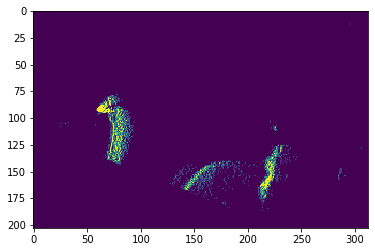

In [251]:
plt.imshow(np.rot90(bev))

In [252]:
_fez = felzenszwalb(bev.astype('float32')/np.max(bev),multichannel=False,min_size=50,sigma=1.5,scale = 500)

(9,)


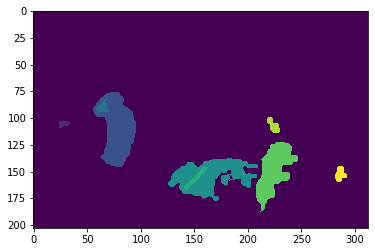

In [253]:
plt.imshow(np.rot90(_fez))
print(np.unique(_fez).shape)

xyz = []
with open(os.path.join(dir_path,'kitti')+'/3d/oyla_'+str(index).zfill(4)+'.xyz','r') as fp:
    for line in fp:
        xyz.append(list(map(float,line[:-1].split(' '))))

def depth_to_bird_view_img(points, factor=1, INPUT_WIDTH=None, INPUT_HEIGHT=None, X_MAX=1500,X_MIN=-1500,Y_MAX=5000,Y_MIN=0 ):
    # Input:
    #   pcd: (N', 4)
    # Output:
    #   birdview: (w, l, 3)
    #X_MAX, Y_MAX,Z_MAX = np.max(points,axis=0)
    #X_MIN, Y_MIN,Z_MIN = np.min(points,axis=0)
    print(np.max(points,axis=0),np.min(points,axis=0))
    if INPUT_WIDTH is None:
        VOXEL_X_SIZE = 16
        VOXEL_Y_SIZE = 12
        INPUT_WIDTH = int((X_MAX - X_MIN) / VOXEL_X_SIZE)
        INPUT_HEIGHT = int((Y_MAX - Y_MIN) / VOXEL_Y_SIZE)
    else:
        VOXEL_X_SIZE = (X_MAX-X_MIN)/INPUT_WIDTH
        VOXEL_Y_SIZE = (Y_MAX-Y_MIN)/INPUT_HEIGHT
    birdview = np.zeros(
        (INPUT_HEIGHT * factor+1, INPUT_WIDTH * factor+1))
    for point in points:
        z,x,y = point[0:3]
        #if X_MIN < x < X_MAX and cfg.Y_MIN < y < cfg.Y_MAX:
        x, y = int((x - X_MIN) / VOXEL_X_SIZE *factor), int((y - Y_MIN) / VOXEL_Y_SIZE * factor)
        birdview[y, INPUT_WIDTH-x] += 1
    birdview = birdview - np.min(birdview)
    divisor = np.max(birdview) - np.min(birdview)
    # TODO: adjust this factor
    birdview = np.clip((birdview / divisor * 255) *
                       5 * factor, a_min=0, a_max=255)
    #birdview = np.tile(birdview, 3).astype(np.uint8)

    return birdview



In [257]:
pcd = o3d.geometry.PointCloud()

In [266]:
xyz = []
with open(os.path.join(dir_path,'kitti')+'/3d/oyla_'+str(122).zfill(4)+'.xyz','r') as fp:
    for line in fp:
        xyz.append(list(map(float,line[:-1].split(' '))))

In [267]:
pcd.points = o3d.utility.Vector3dVector(xyz)

In [268]:
pcd

geometry::PointCloud with 13043 points.

In [3]:
import pickle as pkl

In [32]:
with open('/Users/rsingh/Oyla Dropbox/Oyla/02 Technical/10 Data/44x33/oyla_1_camera_v2/08_Feb_data_February_08_05_41_43/kitti/2d/rgb/yolo.pkl','rb') as fp:
    data = pkl.load(fp)

In [41]:
for y in data['oyla_0107.png']:
    if y[0] == 'person':
        print(y[2])

(39.77357482910156, 117.08448791503906, 72.94696044921875, 157.59033203125)


In [7]:
import scipy.io

In [25]:
A = scipy.io.loadmat('/Users/rsingh/Oyla Dropbox/Oyla/02 Technical/10 Data/44x33/oyla_1_camera_v2/08_Feb_data_February_08_05_41_43/collateral/Test.mat')

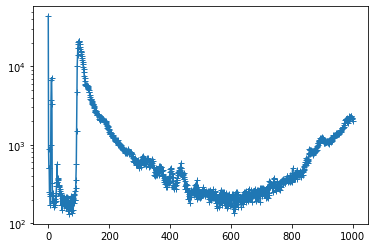

In [29]:
plt.semilogy(A['mask_mismatch'],'-+')

In [31]:
os.path.exists('/Volumes/Samsung_T5/Oyla Dropbox/Oyla/02 Technical/10 Data/44x33/oyla_1_camera_v2/08_Feb_data_February_08_05_41_43/kitti/2d/rgb/yolo.pkl'
            )

True

In [155]:
import cv2

In [164]:
cap = cv2.VideoCapture('/Users/rsingh/Downloads/20200319 205602 Bf8e Accc8eecc5bc.m4v')

In [166]:
i = 0
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    plt.imsave('/Users/rsingh/Downloads/20200319 205602 Bf8e Accc8eecc5bc/axis_'+str(i).zfill(4)+'.png',frame)
    i = i+1

KeyboardInterrupt: 

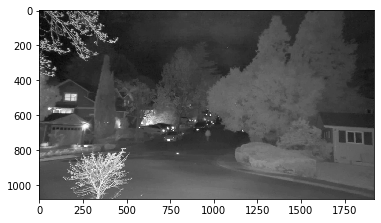

In [168]:
plt.imshow(frame)

In [167]:
cap.release()

In [169]:
import shutil

In [172]:
import glob
files = glob.glob('/Users/rsingh/Downloads/20200319 205602 Bf8e Accc8eecc5bc/*.png')

In [182]:
for i in range(0,len(files),3):
    shutil.copy(files[i],'/Users/rsingh/Downloads/tmp/')

In [178]:
list(range(0,10,2))

[0, 2, 4, 6, 8]

In [189]:
a = plt.imread('/Users/rsingh/Data/44x33/oyla_1_camera_v2/12_Feb_data_February_12_20_16_19/kitti/2d/rgb//oyla_0010.png')

In [190]:
a.shape

(200, 286, 4)

In [ ]:
A = scipy.io.loadmat